In [2]:
!pip install matplotlib-venn

In [3]:
!apt-get -qq install -y libfluidsynth1

E: Package 'libfluidsynth1' has no installation candidate


In [4]:
!pip install cartopy
import cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 88.5 MB/s eta 0:00:00


In [6]:
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 126111 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.6.0-1ubuntu1.4_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.6.0-1ubuntu1.4) ...
Setting up libarchive-dev:amd64 (3.6.0-1ubuntu1.4) ...
Processing triggers for man-db (2.10.2-1) ...
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.0 MB/s eta 0:00:00
  Created wheel for libarchive: filename=libarchive-0.4.7-py3-none-any.whl size=31629 sha256=e6f9154b66c495845a8c2e6298fc9a658715c751e7812288297334608065bd9c
  Stored in directory: /root/.cache/pip/wheels/32/98/bd/4893d6923dd027f455b250367d402bfd69a6f4416581df46db
Successfully built libarchive


In [7]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot

In [10]:
%pip install fuzzywuzzy

In [11]:
import data_cleaning as dc
dc.main()

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [12]:
# Step 1: Load the data
import pandas as pd

df = pd.read_csv('./data/MMNames_clean.csv')

In [13]:
# Step 2: Prepare the data
import data_preprocessing as dp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = dp.preprocess_category(df,'SR_Name')
df = dp.preprocess_onehot(df,'name')

y = df['SR_Name'].values
X = df.drop(columns=['SR_Name']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


(13659, 13003) (5854, 13003)


In [14]:
# Step 3: Build a NN model with TensorFlow
import tensorflow as tf

def create_classification_model(input_shape, num_classes, params={}):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=input_shape),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [15]:
# Step 4: Create and train the model
model = create_classification_model(input_shape=[X_train.shape[1]],num_classes=len(df['SR_Name'].unique()), )
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

In [17]:
# Step 5: Evaluate the model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test, batch_size=32, verbose=0)
y_pred = y_pred.argmax(axis=1)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).round(2).transpose()
report_df.to_csv('./data/cls_report_test.csv', index=False)

y_pred = model.predict(X_train, batch_size=32, verbose=0)
y_pred = y_pred.argmax(axis=1)
report = classification_report(y_train, y_pred, output_dict=True)
report_df = pd.DataFrame(report).round(2).transpose()
report_df.to_csv('./data/cls_report_train.csv', index=False)

In [18]:
import pandas as pd

# To see the number of input features and output classes (for context)
print("Number of input features (N):", X_train.shape[1])
print("Number of output classes:", len(df['SR_Name'].unique()))

Number of input features (N): 13003
Number of output classes: 18


In [19]:
# To see the model summary (for total parameters and layers)
# Re-create the initial model definition temporarily to get its summary
model_initial_cls = create_classification_model(input_shape=[X_train.shape[1]], num_classes=len(df['SR_Name'].unique()))
model_initial_cls.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │       416,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 18)             │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 416,962 (1.59 MB)

 Trainable params: 416,962 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Step 4: Create and train the model (for the initial classification model)
import time

model = create_classification_model(input_shape=[X_train.shape[1]], num_classes=len(df['SR_Name'].unique()))

start_time_initial_cls = time.time()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
end_time_initial_cls = time.time()

training_time_initial_cls = end_time_initial_cls - start_time_initial_cls
print(f"Initial classification model training time: {training_time_initial_cls:.2f} seconds")

Initial classification model training time: 281.18 seconds


In [22]:
import pandas as pd
df_report_train_initial = pd.read_csv('./data/cls_report_train.csv')
df_report_test_initial = pd.read_csv('./data/cls_report_test.csv')
print("Initial Model Train Report:\n", df_report_train_initial.to_string())
print("\nInitial Model Test Report:\n", df_report_test_initial.to_string())

Initial Model Train Report:
     precision  recall  f1-score   support
0        0.81    0.90      0.85   1561.00
1        0.93    0.73      0.82    648.00
2        0.80    0.76      0.78    571.00
3        0.99    0.98      0.99    434.00
4        0.90    0.93      0.92    620.00
5        0.99    0.94      0.96    174.00
6        0.97    0.87      0.92    381.00
7        0.70    0.94      0.80   1580.00
8        0.81    0.83      0.82   1334.00
9        0.92    0.82      0.87    401.00
10       0.97    0.60      0.74    149.00
11       0.97    0.86      0.91    932.00
12       0.89    0.82      0.86   2310.00
13       0.98    0.94      0.96    175.00
14       0.97    0.94      0.95   1004.00
15       0.90    0.88      0.89    428.00
16       0.94    0.90      0.92    372.00
17       0.95    0.77      0.85    585.00
18       0.86    0.86      0.86      0.86
19       0.91    0.86      0.88  13659.00
20       0.88    0.86      0.86  13659.00

Initial Model Test Report:
     precision  rec

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import pandas as pd

# --- Evaluation for TEST Set ---
y_pred_test = model.predict(X_test, batch_size=32, verbose=0)
y_pred_test = y_pred_test.argmax(axis=1)

report_test = classification_report(y_test, y_pred_test, output_dict=True)
report_df_test = pd.DataFrame(report_test).round(2).transpose()
report_df_test.to_csv('./data/cls_report_test.csv', index=False)

print("\nInitial Model Test Report:")
print(report_df_test)
print(f"Test Accuracy: {report_test['accuracy']:.2f}")
print(f"Test Macro Avg F1-score: {report_test['macro avg']['f1-score']:.2f}")
print(f"Test Weighted Avg F1-score: {report_test['weighted avg']['f1-score']:.2f}")


Initial Model Test Report:
              precision  recall  f1-score  support
0                  0.50    0.21      0.30   617.00
1                  0.33    0.14      0.19   273.00
2                  0.39    0.19      0.25   243.00
3                  0.95    0.18      0.30   214.00
4                  0.56    0.17      0.26   258.00
5                  0.89    0.15      0.25    54.00
6                  0.65    0.18      0.28   171.00
7                  0.13    0.68      0.22   664.00
8                  0.36    0.22      0.28   569.00
9                  0.53    0.24      0.33   199.00
10                 0.50    0.08      0.14    85.00
11                 0.70    0.22      0.33   399.00
12                 0.39    0.32      0.35   968.00
13                 0.41    0.11      0.17    82.00
14                 0.71    0.24      0.35   472.00
15                 0.53    0.16      0.25   188.00
16                 0.72    0.28      0.41   152.00
17                 0.54    0.19      0.28   246.00
acc

In [29]:
# --- Evaluation for TRAIN Set ---
y_pred_train = model.predict(X_train, batch_size=32, verbose=0)
y_pred_train = y_pred_train.argmax(axis=1)

report_train = classification_report(y_train, y_pred_train, output_dict=True)
report_df_train = pd.DataFrame(report_train).round(2).transpose()
report_df_train.to_csv('./data/cls_report_train.csv', index=False)

print("\nInitial Model Train Report:")
print(report_df_train)
print(f"Train Accuracy: {report_train['accuracy']:.2f}")
print(f"Train Macro Avg F1-score: {report_train['macro avg']['f1-score']:.2f}")
print(f"Train Weighted Avg F1-score: {report_train['weighted avg']['f1-score']:.2f}")


Initial Model Train Report:
              precision  recall  f1-score   support
0                  0.86    0.85      0.85   1561.00
1                  0.80    0.81      0.80    648.00
2                  0.81    0.77      0.79    571.00
3                  0.98    0.99      0.98    434.00
4                  0.91    0.92      0.92    620.00
5                  0.98    0.95      0.96    174.00
6                  0.90    0.93      0.91    381.00
7                  0.84    0.83      0.83   1580.00
8                  0.77    0.87      0.82   1334.00
9                  0.87    0.86      0.86    401.00
10                 0.86    0.63      0.73    149.00
11                 0.90    0.91      0.91    932.00
12                 0.85    0.85      0.85   2310.00
13                 0.98    0.94      0.96    175.00
14                 0.94    0.97      0.95   1004.00
15                 0.93    0.87      0.90    428.00
16                 0.95    0.90      0.93    372.00
17                 0.91    0.79    

In [30]:
import tensorflow as tf

def create_new_classification_model(input_shape, num_classes, params={}):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),  # First hidden layer, increased neurons
        tf.keras.layers.Dense(64, activation='relu'),   # Second hidden layer, new
        tf.keras.layers.Dense(32, activation='relu'),   # Third hidden layer, original first layer size
        tf.keras.layers.Dense(16, activation='relu'),   # Fourth hidden layer, original second layer size
        tf.keras.layers.Dense(num_classes, activation='softmax') # Output layer
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# To see the model summary of the deeper model (run this after defining the function)
# Ensure X_train.shape[1] and len(df['SR_Name'].unique()) are available from previous cells
model_new_cls = create_new_classification_model(input_shape=[X_train.shape[1]], num_classes=len(df['SR_Name'].unique()))
model_new_cls.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │     1,664,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 18)             │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,675,682 (6.39 MB)

 Trainable params: 1,675,682 (6.39 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
import time

print("\n--- Training New Classification Model ---")

start_time_new_cls = time.time()
history_new = model_new_cls.fit(X_train, y_train, epochs=50, batch_size=32,validation_data=(X_test, y_test), verbose=0)
end_time_new_cls = time.time()

training_time_new_cls = end_time_new_cls - start_time_new_cls
print(f"New classification model training time: {training_time_new_cls:.2f} seconds")


--- Training New Classification Model ---
New classification model training time: 922.67 seconds


In [32]:
import pandas as pd
from sklearn.metrics import classification_report

# --- Evaluation for New Model TEST Set ---
y_pred_new_test = model_new_cls.predict(X_test, batch_size=32, verbose=0)
y_pred_new_test = y_pred_new_test.argmax(axis=1) # Convert probabilities to class labels

report_new_test = classification_report(y_test, y_pred_new_test, output_dict=True)
report_df_new_test = pd.DataFrame(report_new_test).round(2).transpose()
report_df_new_test.to_csv('./data/cls_report_new_test.csv', index=False) # NEW FILENAME

print("\n New Model Test Report:")
print(report_df_new_test)
print(f"New Test Accuracy: {report_new_test['accuracy']:.2f}")
print(f"New Test Macro Avg F1-score: {report_new_test['macro avg']['f1-score']:.2f}")
print(f"New Test Weighted Avg F1-score: {report_new_test['weighted avg']['f1-score']:.2f}")


 New Model Test Report:
              precision  recall  f1-score  support
0                  0.43    0.23      0.30   617.00
1                  0.45    0.11      0.18   273.00
2                  0.34    0.18      0.24   243.00
3                  0.93    0.18      0.30   214.00
4                  0.52    0.17      0.25   258.00
5                  1.00    0.15      0.26    54.00
6                  0.52    0.18      0.26   171.00
7                  0.13    0.73      0.23   664.00
8                  0.45    0.21      0.28   569.00
9                  0.57    0.25      0.35   199.00
10                 0.44    0.08      0.14    85.00
11                 0.71    0.20      0.31   399.00
12                 0.54    0.30      0.39   968.00
13                 0.34    0.12      0.18    82.00
14                 0.75    0.23      0.35   472.00
15                 0.53    0.16      0.25   188.00
16                 0.71    0.30      0.42   152.00
17                 0.36    0.22      0.27   246.00
accura

In [33]:
# --- Evaluation for New Model TRAIN Set ---
y_pred_new_train = model_new_cls.predict(X_train, batch_size=32, verbose=0)
y_pred_new_train = y_pred_new_train.argmax(axis=1) # Convert probabilities to class labels

report_new_train = classification_report(y_train, y_pred_new_train, output_dict=True)
report_df_new_train = pd.DataFrame(report_new_train).round(2).transpose()
report_df_new_train.to_csv('./data/cls_report_new_train.csv', index=False) # NEW FILENAME

print("\n New Model Train Report:")
print(report_df_new_train)
print(f"New Train Accuracy: {report_new_train['accuracy']:.2f}")
print(f"New Train Macro Avg F1-score: {report_new_train['macro avg']['f1-score']:.2f}")
print(f"New Train Weighted Avg F1-score: {report_new_train['weighted avg']['f1-score']:.2f}")


 New Model Train Report:
              precision  recall  f1-score   support
0                  0.85    0.85      0.85   1561.00
1                  0.93    0.72      0.81    648.00
2                  0.78    0.80      0.79    571.00
3                  0.99    0.99      0.99    434.00
4                  0.92    0.92      0.92    620.00
5                  1.00    0.93      0.96    174.00
6                  0.88    0.91      0.89    381.00
7                  0.85    0.81      0.83   1580.00
8                  0.82    0.81      0.82   1334.00
9                  0.86    0.85      0.86    401.00
10                 0.94    0.62      0.75    149.00
11                 0.93    0.88      0.90    932.00
12                 0.82    0.89      0.85   2310.00
13                 0.90    0.99      0.95    175.00
14                 0.94    0.96      0.95   1004.00
15                 0.94    0.85      0.89    428.00
16                 0.91    0.92      0.91    372.00
17                 0.74    0.90      0

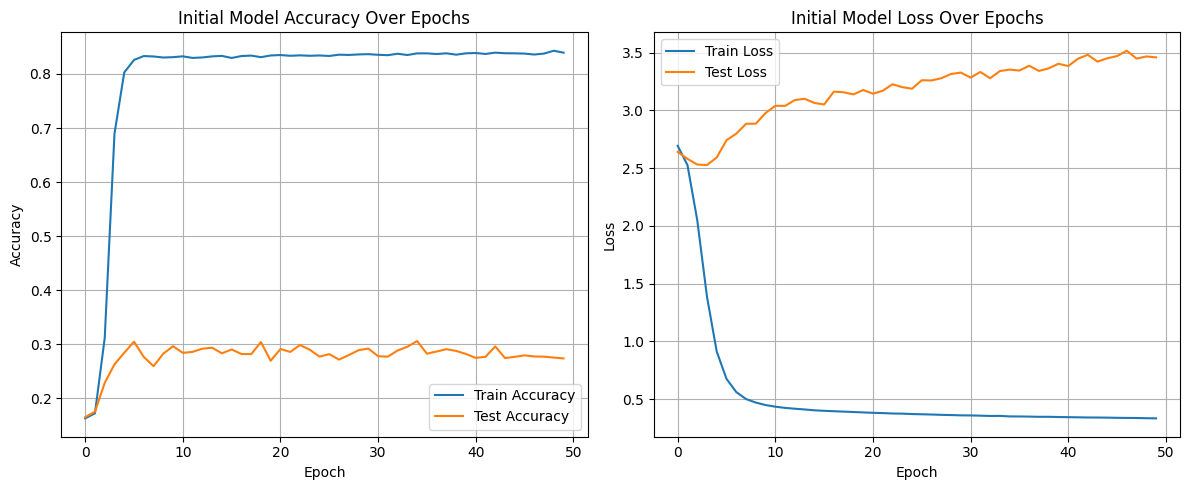

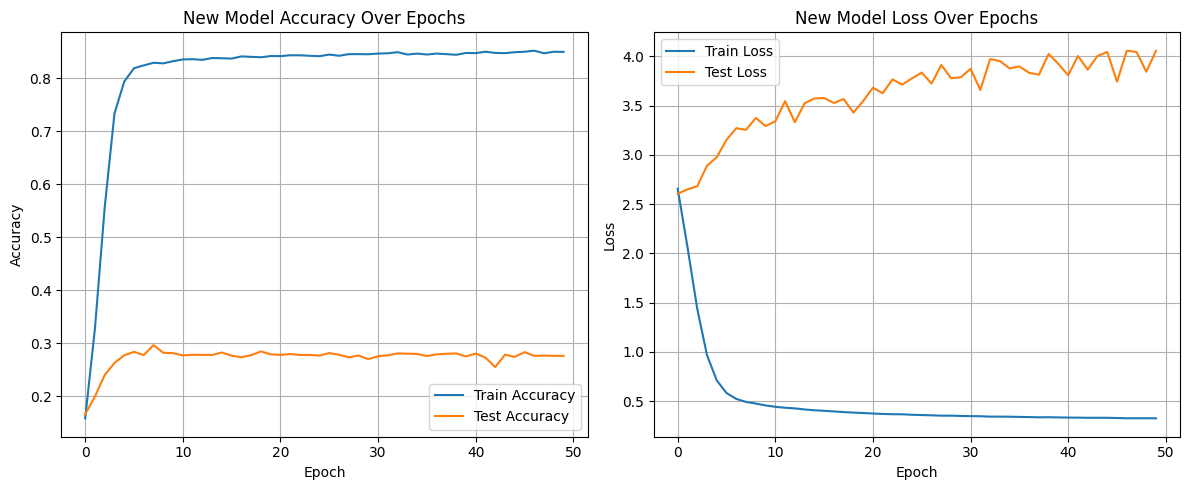

In [37]:
import matplotlib.pyplot as plt

# Plot for Initial Model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy') # 'val_accuracy' refers to validation/test accuracy
plt.title('Initial Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss') # 'val_loss' refers to validation/test loss
plt.title('Initial Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot for New Model (similar structure)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_new.history['accuracy'], label='Train Accuracy')
plt.plot(history_new.history['val_accuracy'], label='Test Accuracy')
plt.title('New Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_new.history['loss'], label='Train Loss')
plt.plot(history_new.history['val_loss'], label='Test Loss')
plt.title('New Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()